<a href="https://colab.research.google.com/github/SamudiniD/Efficient-Denoising-for-single-band-astronomical-images/blob/main/noise2void_ep100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Noise2Void with *PS1 Dataset*

Epoch 1/100
106/106 - 133s - 1s/step - loss: 0.0324 - val_loss: 0.0038
Epoch 2/100
106/106 - 130s - 1s/step - loss: 0.0035 - val_loss: 0.0030
Epoch 3/100
106/106 - 121s - 1s/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/100
106/106 - 128s - 1s/step - loss: 0.0022 - val_loss: 0.0020
Epoch 5/100
106/106 - 141s - 1s/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/100
106/106 - 141s - 1s/step - loss: 0.0011 - val_loss: 9.9408e-04
Epoch 7/100
106/106 - 137s - 1s/step - loss: 9.6873e-04 - val_loss: 9.2864e-04
Epoch 8/100
106/106 - 126s - 1s/step - loss: 9.1144e-04 - val_loss: 8.7802e-04
Epoch 9/100
106/106 - 148s - 1s/step - loss: 8.6397e-04 - val_loss: 8.3414e-04
Epoch 10/100
106/106 - 131s - 1s/step - loss: 8.2285e-04 - val_loss: 7.9542e-04
Epoch 11/100
106/106 - 126s - 1s/step - loss: 7.8066e-04 - val_loss: 7.4785e-04
Epoch 12/100
106/106 - 142s - 1s/step - loss: 7.3615e-04 - val_loss: 7.1215e-04
Epoch 13/100
106/106 - 148s - 1s/step - loss: 7.0885e-04 - val_loss: 6.9098e-04
Epoch 14/100


✅ Model saved to: /content/drive/MyDrive/PS1_Models/noise2void_model_ep100.h5


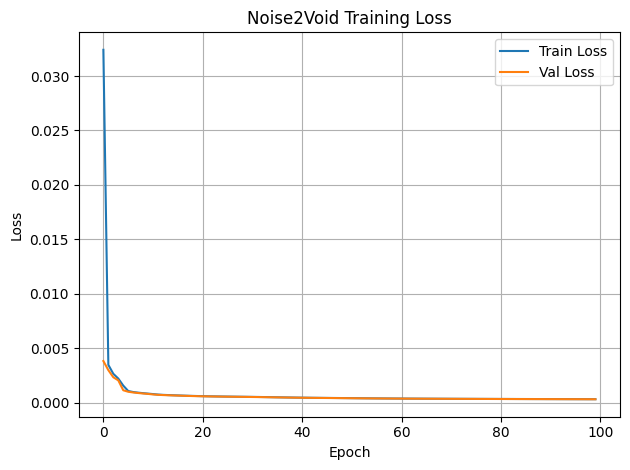

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# === Load the noisy images ===
noisy_path = ('/content/drive/MyDrive/PS1_Dataset/augmented_noisy.npy')
noisy_data = np.load(noisy_path)

# === Normalize safely ===
noisy_data = np.nan_to_num(noisy_data, nan=0.0, posinf=1.0, neginf=0.0)
noisy_data = (noisy_data - noisy_data.min()) / (noisy_data.max() - noisy_data.min())
noisy_data = np.expand_dims(noisy_data.astype('float32'), axis=-1)

# === Create masked input for Noise2Void ===
def create_n2v_data(images, mask_ratio=0.05):
    masked_inputs = []
    targets = []
    for img in images:
        mask = np.random.rand(*img.shape) < mask_ratio
        masked = img.copy()
        masked[mask] = 0.0  # simulate blind spot
        masked_inputs.append(masked)
        targets.append(img)
    return np.array(masked_inputs), np.array(targets)

masked_X, targets = create_n2v_data(noisy_data.squeeze(), mask_ratio=0.05)
masked_X = np.expand_dims(masked_X, -1)
targets = np.expand_dims(targets, -1)

# === Split dataset ===
X_train, X_test, Y_train, Y_test = train_test_split(masked_X, targets, test_size=0.2, random_state=42)

# === Define Noise2Void-style Autoencoder ===
def build_n2v_model():
    input_layer = layers.Input(shape=(240, 240, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(input_layer, output)

model = build_n2v_model()
model.compile(optimizer='adam', loss='mean_squared_error')

# === Train model ===
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=100,
    batch_size=8,
    shuffle=True,
    verbose=2
)

# === Save model ===
model_path = '/content/drive/MyDrive/PS1_Models/noise2void_model_ep100.h5'
model.save(model_path)
print("✅ Model saved to:", model_path)

# === Plot training curves ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Noise2Void Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step

📊 Evaluation Summary:
Samples Evaluated: 1055
Average PSNR: 23.579
Average SSIM: 0.121
Average MSE:  0.004410
Average MAE:  0.043200


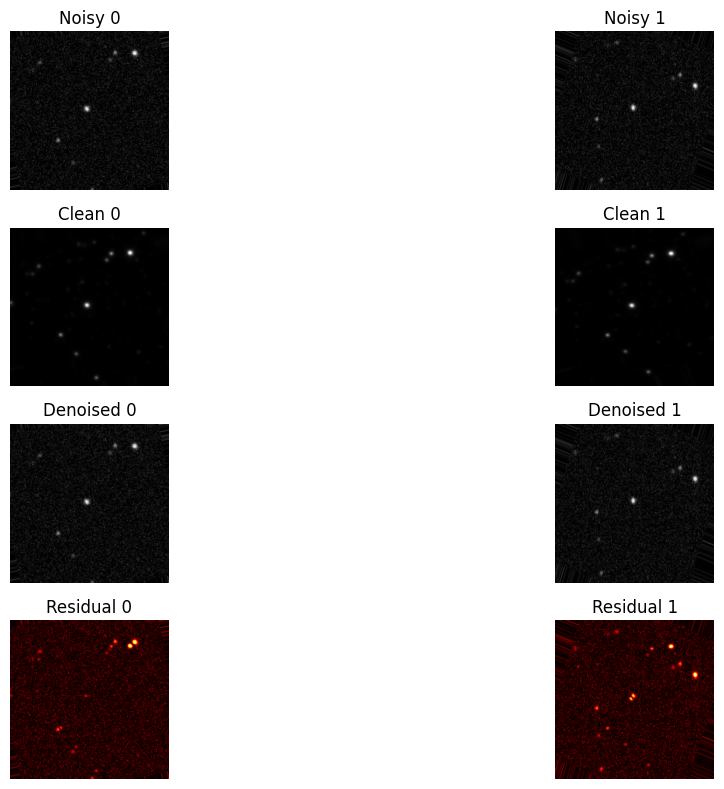

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error

# === Load data ===
X = np.load('/content/drive/MyDrive/PS1_Dataset/augmented_noisy.npy')
Y = np.load('/content/drive/MyDrive/PS1_Dataset/augmented_clean.npy')

# Normalize and reshape
X = np.nan_to_num(X, nan=0.0, posinf=1.0, neginf=0.0)
Y = np.nan_to_num(Y, nan=0.0, posinf=1.0, neginf=0.0)
X = (X - X.min()) / (X.max() - X.min())
Y = (Y - Y.min()) / (Y.max() - Y.min())
X = np.expand_dims(X, axis=-1).astype('float32')
Y = np.expand_dims(Y, axis=-1).astype('float32')

# === Load trained Noise2Void model ===
model = tf.keras.models.load_model('/content/drive/MyDrive/PS1_Models/noise2void_model_ep100.h5')

# === Predict ===
Y_pred = model.predict(X, verbose=1)
Y_pred = np.nan_to_num(Y_pred, nan=0.0, posinf=1.0, neginf=0.0)

# === Evaluation Metrics ===
psnr_scores, ssim_scores, mse_scores, mae_scores = [], [], [], []
for i in range(len(X)):
    gt = Y[i].squeeze()
    pred = Y_pred[i].squeeze()
    psnr_scores.append(psnr(gt, pred, data_range=1.0))
    ssim_scores.append(ssim(gt, pred, data_range=1.0))
    mse_scores.append(mean_squared_error(gt, pred))
    mae_scores.append(mean_absolute_error(gt, pred))

print("\n📊 Evaluation Summary:")
print(f"Samples Evaluated: {len(X)}")
print(f"Average PSNR: {np.mean(psnr_scores):.3f}")
print(f"Average SSIM: {np.mean(ssim_scores):.3f}")
print(f"Average MSE:  {np.mean(mse_scores):.6f}")
print(f"Average MAE:  {np.mean(mae_scores):.6f}")

# === Visualize samples ===
n = 2
fig, axs = plt.subplots(4, n, figsize=(15, 8))
for i in range(n):
    axs[0, i].imshow(X[i].squeeze(), cmap='gray')
    axs[0, i].set_title(f"Noisy {i}")
    axs[0, i].axis('off')

    axs[1, i].imshow(Y[i].squeeze(), cmap='gray')
    axs[1, i].set_title(f"Clean {i}")
    axs[1, i].axis('off')

    axs[2, i].imshow(Y_pred[i].squeeze(), cmap='gray', vmin=0, vmax=1)
    axs[2, i].set_title(f"Denoised {i}")
    axs[2, i].axis('off')

    axs[3, i].imshow(np.abs(Y[i].squeeze() - Y_pred[i].squeeze()), cmap='hot')
    axs[3, i].set_title(f"Residual {i}")
    axs[3, i].axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


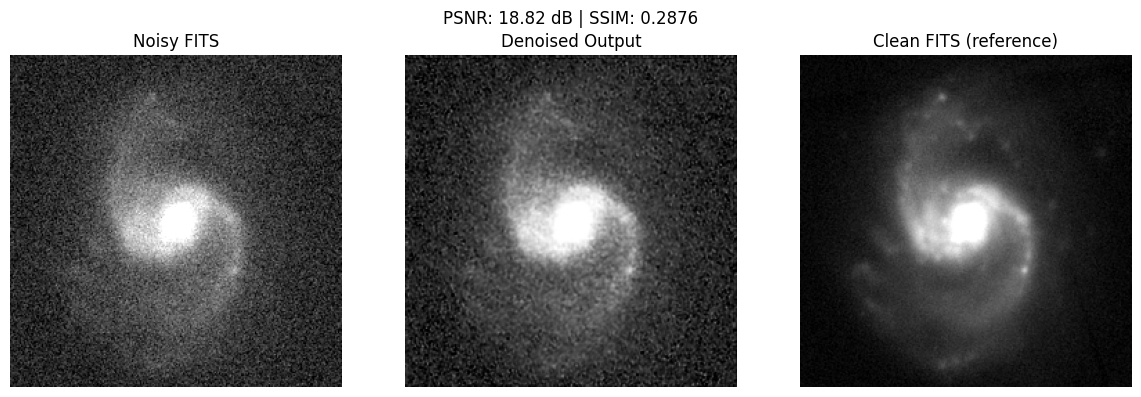

In [ ]:
# Re-import necessary modules after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# -----------------------------
# 1. Load Model
# -----------------------------
model_path = "/content/drive/MyDrive/PS1_Models/noise2void_model_ep100.h5"
model = load_model(model_path)

# -----------------------------
# 2. Load FITS Image Pair
# -----------------------------
clean_path = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"
noisy_path = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"

def load_fits_normalized(path):
    with fits.open(path) as hdul:
        img = hdul[0].data.astype(np.float32)
        img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
        p1, p99 = np.percentile(img, (1, 99))
        img = np.clip(img, p1, p99)
        img = (img - p1) / (p99 - p1 + 1e-8)
        img = np.log1p(img) / np.log1p(1.0)
        return img

noisy = load_fits_normalized(noisy_path)
clean = load_fits_normalized(clean_path)

# Resize to 240x240
noisy_resized = tf.image.resize(noisy[..., np.newaxis], (240, 240)).numpy().squeeze()
clean_resized = tf.image.resize(clean[..., np.newaxis], (240, 240)).numpy().squeeze()

# -----------------------------
# 3. Predict
# -----------------------------
input_tensor = noisy_resized[np.newaxis, ..., np.newaxis]
denoised = model.predict(input_tensor)[0, ..., 0]

# -----------------------------
# 4. PSNR + SSIM
# -----------------------------
psnr = psnr_metric(clean_resized, denoised, data_range=1.0)
ssim = ssim_metric(clean_resized, denoised, data_range=1.0)

# -----------------------------
# 5. Plot results
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, img, title in zip(axes, [noisy_resized, denoised, clean_resized],
                          ["Noisy FITS", "Denoised Output", "Clean FITS (reference)"]):
    ax.imshow(img, cmap="gray", vmin=np.percentile(img, 1), vmax=np.percentile(img, 99))
    ax.set_title(title)
    ax.axis("off")

plt.suptitle(f"PSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}")
plt.tight_layout()
plt.show()


#Noise2Void_ep100_augmented_noise_dataset

In [ ]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from astropy.io import fits

# Define paths to directories (not individual files)
noisy_dir = '/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/noisy'
clean_dir = '/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/clean'

# Load all .npy files in the folder and stack them into arrays
noisy_data = []
clean_data = []

# Loop through the files in the noisy and clean directories
for f in sorted(os.listdir(noisy_dir)):
    if f.endswith('.npy'):
        noisy_data.append(np.load(os.path.join(noisy_dir, f)))

for f in sorted(os.listdir(clean_dir)):
    if f.endswith('.npy'):
        clean_data.append(np.load(os.path.join(clean_dir, f)))

# Convert the lists into numpy arrays
noisy_data = np.array(noisy_data)
clean_data = np.array(clean_data)

# ------------------------------- Data Augmentation Functions -------------------------------
def add_gaussian_noise(image, mean=0.0, std=0.05):
    noise = np.random.normal(mean, std, image.shape)
    return np.clip(image + noise, 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = image.copy()
    total_pixels = image.shape[0] * image.shape[1]
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    # Salt noise
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 1.0

    # Pepper noise
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 0.0

    return noisy_image

# Generate noisy augmented data
def augment_data(X, Y, num_augmentations=10):
    X_augmented = []
    Y_augmented = []

    for img in X:
        for _ in range(num_augmentations):
            if np.random.rand() < 0.5:
                img_aug = add_gaussian_noise(img)
            else:
                img_aug = add_salt_and_pepper(img)
            X_augmented.append(img_aug)
            Y_augmented.append(img)  # Clean images as targets

    return np.array(X_augmented), np.array(Y_augmented)

# ------------------------------- Preprocess FITS images -------------------------------
def preprocess_fits(path, target_size=(240, 240)):
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs and infinite values
        p1, p99 = np.percentile(data, (1, 99))  # Clip the data
        data = np.clip(data, p1, p99)
        data = (data - p1) / (p99 - p1 + 1e-8)  # Normalize to range [0, 1]
        data = tf.image.resize(data[..., np.newaxis], target_size).numpy().squeeze()  # Resize image
        return data

# Load and preprocess images
noisy_img = preprocess_fits(noisy_dir + "/galaxy_004_noisy.fits")  # Sample FITS file path
clean_img = preprocess_fits(clean_dir + "/galaxy_004_clean.fits")  # Sample FITS file path

# Augment the noisy data
X, Y = augment_data([noisy_img], [clean_img], num_augmentations=100)

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# ------------------------------- N2V Model -------------------------------
def build_n2v_model(input_shape=(240, 240, 1)):
    input_layer = layers.Input(shape=input_shape)

    # Encoder path: downsampling
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder path: upsampling
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)

    # Final output layer
    output_layer = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_layer, output_layer)

# Build and compile the model
n2v_model = build_n2v_model()
n2v_model.compile(optimizer='adam', loss='mean_squared_error')

# ------------------------------- Train the Model -------------------------------
history = n2v_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=8,
    shuffle=True,
    verbose=2
)

# Save the trained model
n2v_model.save("/content/drive/MyDrive/PS1_Models/n2v_model.h5")
print("✅ N2V model saved!")

# ------------------------------- Evaluation -------------------------------
# Predict denoised image
denoised_img = n2v_model.predict(X_val)[0]

# Evaluate PSNR and SSIM
psnr = psnr_metric(Y_val[0], denoised_img, data_range=1.0)
ssim = ssim_metric(Y_val[0], denoised_img, data_range=1.0)

print("\n📊 Evaluation Metrics:")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

# ------------------------------- Visualize Results -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, img, title in zip(
    axes,
    [X_val[0], denoised_img, Y_val[0]],
    ["Noisy FITS", f"Denoised Output\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}", "Clean FITS (Reference)"]
):
    ax.imshow(img, cmap="gray", vmin=np.percentile(img, 1), vmax=np.percentile(img, 99))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


✅ Model loaded!

📊 Evaluation Metrics:
PSNR: 19.33 dB
SSIM: 0.2284


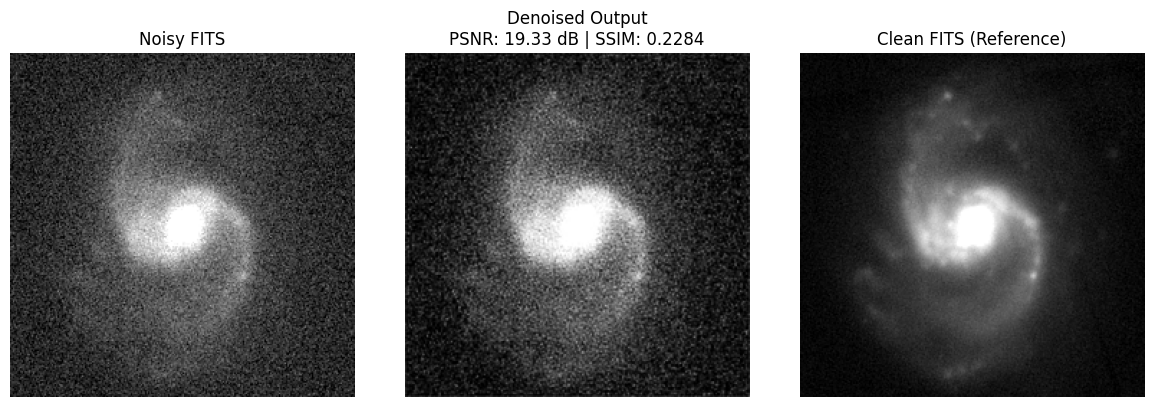

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from astropy.io import fits
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# -----------------------------
# 1. Define custom loss again
# -----------------------------
def ssim_mse_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.5 * mse_loss + 0.5 * ssim_loss

# -----------------------------
# 2. Load model with custom_objects
# -----------------------------
model_path = '/content/drive/MyDrive/PS1_Models/noise2void_model_augmented_ep100.h5'  # Update with your fine-tuned model path
model = tf.keras.models.load_model(model_path, custom_objects={'ssim_mse_loss': ssim_mse_loss})
print("✅ Model loaded!")

# -----------------------------
# 3. Load FITS Image Pair (Noisy and Clean)
# -----------------------------
noisy_path = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"
clean_path = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"

def load_fits_normalized(path):
    with fits.open(path) as hdul:
        img = hdul[0].data.astype(np.float32)
        img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
        p1, p99 = np.percentile(img, (1, 99))
        img = np.clip(img, p1, p99)
        img = (img - p1) / (p99 - p1 + 1e-8)
        img = np.log1p(img) / np.log1p(1.0)
        return img

noisy_img = load_fits_normalized(noisy_path)
clean_img = load_fits_normalized(clean_path)

# Resize to 240x240 for model input
noisy_resized = tf.image.resize(noisy_img[..., np.newaxis], (240, 240)).numpy().squeeze()
clean_resized = tf.image.resize(clean_img[..., np.newaxis], (240, 240)).numpy().squeeze()

# -----------------------------
# 4. Predict denoised output
# -----------------------------
input_tensor = noisy_resized[np.newaxis, ..., np.newaxis]
denoised = model.predict(input_tensor, verbose=0)[0, ..., 0]

# -----------------------------
# 5. Evaluation Metrics (PSNR & SSIM)
# -----------------------------
psnr = psnr_metric(clean_resized, denoised, data_range=1.0)
ssim = ssim_metric(clean_resized, denoised, data_range=1.0)

print("\n📊 Evaluation Metrics:")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

# -----------------------------
# 6. Visualization
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, img, title in zip(
    axes,
    [noisy_resized, denoised, clean_resized],
    ["Noisy FITS", f"Denoised Output\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}", "Clean FITS (Reference)"]
):
    ax.imshow(img, cmap="gray", vmin=np.percentile(img, 1), vmax=np.percentile(img, 99))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


# U-Net Denoising Model with Skip-Connections

## This function defines a U-Net style convolutional autoencoder tailored for image denoising. Unlike a plain encoder–decoder, U-Net introduces skip connections between corresponding encoder and decoder layers, which:
   1. Preserve fine-grained spatial details (e.g., spiral arms, star-forming knots)
   2. Provide direct high-resolution feature maps to the decoder, reducing
      the need to reconstruct fine structure from a compressed bottleneck
   3. Improve gradient flow, speeding up training and helping avoid collapse

# Architecture overview:
   - Encoder path: 3 × (Conv2D → ReLU → MaxPool)
   - Bottleneck:    Conv2D with higher channel depth for feature abstraction
   - Decoder path: 3 × (Conv2DTranspose → ReLU) with concatenation of encoder
                  feature maps at each level (skip connections)
   - Final layer: Conv2D(1, kernel_size=3, activation='sigmoid') for a single-
                  channel output in [0,1]


Loaded dataset: X=(1050, 240, 240, 1), Y=(1050, 240, 240, 1)
After augmentation: X_train=(1680, 240, 240, 1), Y_train=(1680, 240, 240, 1)
Epoch 1/100
210/210 - 6s - 28ms/step - loss: 0.0228 - val_loss: 0.0225
Epoch 2/100
210/210 - 2s - 8ms/step - loss: 0.0212 - val_loss: 0.0218
Epoch 3/100
210/210 - 2s - 8ms/step - loss: 0.0205 - val_loss: 0.0218
Epoch 4/100
210/210 - 2s - 8ms/step - loss: 0.0202 - val_loss: 0.0218
Epoch 5/100
210/210 - 2s - 8ms/step - loss: 0.0199 - val_loss: 0.0213
Epoch 6/100
210/210 - 2s - 8ms/step - loss: 0.0196 - val_loss: 0.0215
Epoch 7/100
210/210 - 2s - 8ms/step - loss: 0.0195 - val_loss: 0.0210
Epoch 8/100
210/210 - 2s - 8ms/step - loss: 0.0194 - val_loss: 0.0212
Epoch 9/100
210/210 - 2s - 8ms/step - loss: 0.0192 - val_loss: 0.0212
Epoch 10/100
210/210 - 2s - 8ms/step - loss: 0.0191 - val_loss: 0.0212
Epoch 11/100
210/210 - 2s - 8ms/step - loss: 0.0191 - val_loss: 0.0212
Epoch 12/100
210/210 - 2s - 8ms/step - loss: 0.0191 - val_loss: 0.0210
Epoch 13/100
210/2

✅ Model trained & saved!

📊 Inference Timing
 • Total: 16.30s   Avg/image: 0.0776s

📈 PSNR
 • Mean: 17.03 dB   Std: 1.11   95% CI: (16.88, 17.18)

📈 SSIM
 • Mean: 0.0761   Std: 0.0215   95% CI: (0.0732, 0.0790)


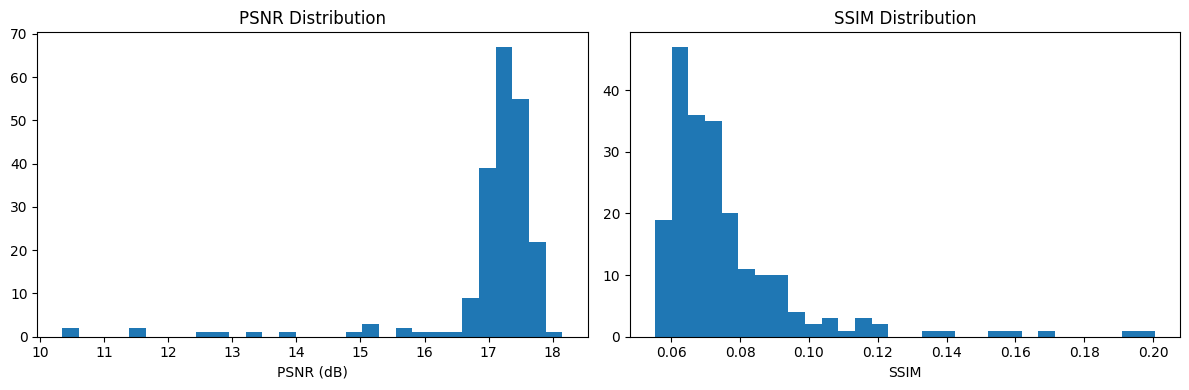

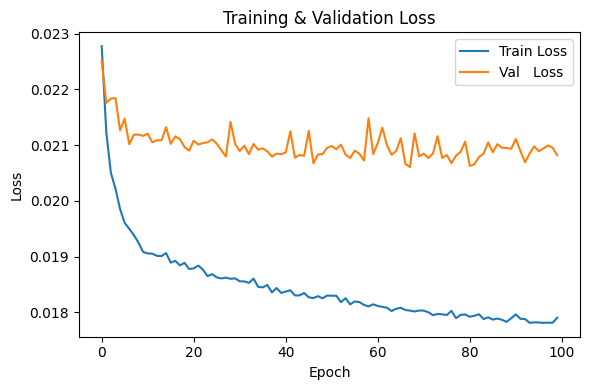

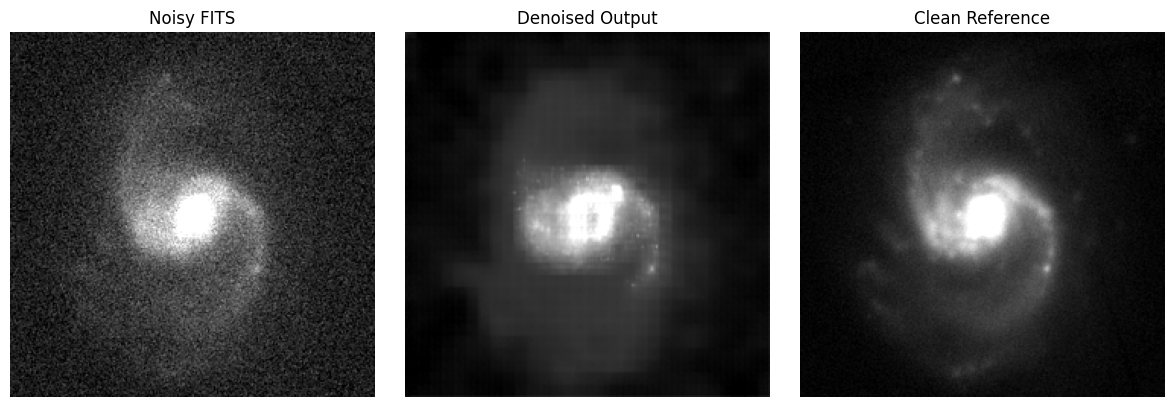

In [5]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy import stats
import matplotlib.pyplot as plt
from astropy.io import fits

# ------------------------------- 1. Dataset Loader -------------------------------
def load_dataset():
    X = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy")
    Y = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy")

    X = np.clip(X, 0, 1).astype(np.float32)
    Y = np.clip(Y, 0, 1).astype(np.float32)

    if X.ndim == 3:    X = X[..., np.newaxis]
    if Y.ndim == 3:    Y = Y[..., np.newaxis]

    return X, Y

# ------------------------------- 2. Augmentation Functions -------------------------------
def add_gaussian_noise(image, std=0.05):
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    noisy = image.copy()
    total = image.shape[0] * image.shape[1]
    coords = [np.random.randint(0, i, int(total*salt_prob)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], 0] = 1.0
    coords = [np.random.randint(0, i, int(total*pepper_prob)) for i in image.shape[:2]]
    noisy[coords[0], coords[1], 0] = 0.0
    return noisy

def add_poisson_noise(image):
    return np.clip(np.random.poisson(image * 255) / 255.0, 0, 1)

def add_mixed_noise(image):
    return add_gaussian_noise(image) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

def augment_data(X_clean):
    """
    Given a batch of clean images, return:
      - X_noisy: the same images with mixed noise
      - Y_clean: the original clean images (unchanged)
    """
    X_noisy  = np.array([add_mixed_noise(img) for img in X_clean])
    Y_clean  = X_clean.copy()
    return X_noisy, Y_clean

# ------------------------------- 3. Load & Split -------------------------------
X, Y = load_dataset()
print(f"Loaded dataset: X={X.shape}, Y={Y.shape}")

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Augment ONLY the inputs, keeping targets clean
X_train_noisy, Y_train_clean = augment_data(Y_train)
X_train = np.concatenate([X_train, X_train_noisy], axis=0)
Y_train = np.concatenate([Y_train, Y_train_clean], axis=0)
print(f"After augmentation: X_train={X_train.shape}, Y_train={Y_train.shape}")

# ------------------------------- 4. Model Definition -------------------------------
def build_n2v_model(input_shape):
    inp = layers.Input(shape=input_shape)
    # Encoder
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = layers.MaxPooling2D(2,2,padding='same')(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = layers.MaxPooling2D(2,2,padding='same')(x)
    x = layers.Conv2D(128,3,activation='relu',padding='same')(x)
    x = layers.MaxPooling2D(2,2,padding='same')(x)
    # Decoder
    x = layers.Conv2DTranspose(128,3,strides=2,activation='relu',padding='same')(x)
    x = layers.Conv2DTranspose(64,3,strides=2,activation='relu',padding='same')(x)
    x = layers.Conv2DTranspose(32,3,strides=2,activation='relu',padding='same')(x)
    out = layers.Conv2D(1,3,activation='sigmoid',padding='same')(x)
    return models.Model(inp, out)

input_shape = X_train.shape[1:]     # e.g. (240,240,1)
n2v_model   = build_n2v_model(input_shape)
n2v_model.compile(optimizer='adam', loss='mean_squared_error')

# ------------------------------- 5. Training -------------------------------
history = n2v_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=8,
    shuffle=True,
    verbose=2
)
n2v_model.save("/content/drive/MyDrive/PS1_Models/n2v_model_with_fixed_aug.h5")
print("✅ Model trained & saved!")

# ------------------------------- 6. Per-Image Metrics & Timing -------------------------------
psnr_vals, ssim_vals = [], []
start_t = time.time()
for i in range(len(X_val)):
    inp = X_val[i:i+1]
    den = n2v_model.predict(inp, verbose=0)[0,...,0]
    gt  = Y_val[i,...,0]
    psnr_vals.append(peak_signal_noise_ratio(gt, den, data_range=1.0))
    ssim_vals.append(structural_similarity(gt, den, data_range=1.0))
end_t = time.time()

# Statistics
total_time = end_t - start_t
avg_time   = total_time / len(X_val)
psnr_arr   = np.array(psnr_vals)
ssim_arr   = np.array(ssim_vals)
psnr_mean, psnr_std = psnr_arr.mean(), psnr_arr.std()
ssim_mean, ssim_std = ssim_arr.mean(), ssim_arr.std()
n = len(psnr_arr)
ci_psnr = stats.norm.interval(0.95, loc=psnr_mean, scale=psnr_std/np.sqrt(n))
ci_ssim = stats.norm.interval(0.95, loc=ssim_mean, scale=ssim_std/np.sqrt(n))

print("\n📊 Inference Timing")
print(f" • Total: {total_time:.2f}s   Avg/image: {avg_time:.4f}s")
print("\n📈 PSNR")
print(f" • Mean: {psnr_mean:.2f} dB   Std: {psnr_std:.2f}   95% CI: ({ci_psnr[0]:.2f}, {ci_psnr[1]:.2f})")
print("\n📈 SSIM")
print(f" • Mean: {ssim_mean:.4f}   Std: {ssim_std:.4f}   95% CI: ({ci_ssim[0]:.4f}, {ci_ssim[1]:.4f})")

# ------------------------------- 7. Optional Histograms -------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(psnr_arr, bins=30); plt.title("PSNR Distribution"); plt.xlabel("PSNR (dB)")
plt.subplot(1,2,2)
plt.hist(ssim_arr, bins=30); plt.title("SSIM Distribution"); plt.xlabel("SSIM")
plt.tight_layout(); plt.show()

# ------------------------------- 8. Loss Curve -------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],      label='Train Loss')
plt.plot(history.history['val_loss'],  label='Val   Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------- 9. FITS Triplet Visualization -------------------------------
def load_fits_normalized(path, target_size=(240,240)):
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    p1, p99 = np.percentile(data, (1,99))
    data = np.clip(data, p1, p99)
    data = (data - p1) / (p99 - p1 + 1e-8)
    return tf.image.resize(data[...,None], target_size).numpy().squeeze()

noisy_path = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"
clean_path = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"

noisy_img = load_fits_normalized(noisy_path)
clean_img = load_fits_normalized(clean_path)
inp = noisy_img[np.newaxis,...,None]
denoised = n2v_model.predict(inp, verbose=0)[0,...,0]

fig, axes = plt.subplots(1,3,figsize=(12,4))
for ax, img, title in zip(axes,
                          [noisy_img, denoised, clean_img],
                          ["Noisy FITS", "Denoised Output", "Clean Reference"]):
    ax.imshow(img, cmap='gray',
              vmin=np.percentile(img,1),
              vmax=np.percentile(img,99))
    ax.set_title(title); ax.axis('off')
plt.tight_layout(); plt.show()


#Noise2Void model with *SDSS DATASET*

In [ ]:
import os
import numpy as np
from astropy.io import fits

# Set directories
augmented_noisy_dir = "/content/drive/MyDrive/sdss_image_dataset/augmented/train/noisy"
augmented_clean_dir = "/content/drive/MyDrive/sdss_image_dataset/augmented/train/clean"

# Create directories if they don't exist
os.makedirs(augmented_noisy_dir, exist_ok=True)
os.makedirs(augmented_clean_dir, exist_ok=True)

# Get list of augmented FITS file paths
augmented_noisy_paths = sorted([os.path.join(augmented_noisy_dir, f) for f in os.listdir(augmented_noisy_dir) if f.endswith('.fits')])
augmented_clean_paths = sorted([os.path.join(augmented_clean_dir, f) for f in os.listdir(augmented_clean_dir) if f.endswith('.fits')])

# Function to convert FITS files to npy
def convert_fits_to_npy(fits_paths, save_dir, prefix="aug"):
    npy_paths = []
    for fits_path in fits_paths:
        # Read the FITS file
        data = fits.getdata(fits_path)

        # Save to numpy format
        filename = os.path.basename(fits_path).replace('.fits', '.npy')
        npy_path = os.path.join(save_dir, filename)

        # Save the numpy array
        np.save(npy_path, data)

        npy_paths.append(npy_path)

    return npy_paths

# Convert augmented noisy and clean images to npy
noisy_npy_paths = convert_fits_to_npy(augmented_noisy_paths, "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/noisy")
clean_npy_paths = convert_fits_to_npy(augmented_clean_paths, "/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/clean")

print(f"Converted {len(noisy_npy_paths)} noisy augmented images to npy.")
print(f"Converted {len(clean_npy_paths)} clean augmented images to npy.")


Converted 4200 noisy augmented images to npy.
Converted 4200 clean augmented images to npy.


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim_metric
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define dataset paths (SDSS augmented data in .npy format)
noisy_npy_paths = sorted([os.path.join("/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/noisy", f) for f in os.listdir("/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/noisy") if f.endswith('.npy')])
clean_npy_paths = sorted([os.path.join("/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/clean", f) for f in os.listdir("/content/drive/MyDrive/sdss_image_dataset/augmented/npy/train/clean") if f.endswith('.npy')])

# Function to load .npy data
def load_npy_data(noisy_paths, clean_paths):
    X = np.array([np.load(path) for path in noisy_paths])  # Noisy images
    Y = np.array([np.load(path) for path in clean_paths])  # Clean images
    return X, Y

# Load training data
X_train, Y_train = load_npy_data(noisy_npy_paths, clean_npy_paths)

# Normalize the data
X_train = X_train.astype('float32') / 255.0
Y_train = Y_train.astype('float32') / 255.0

# Ensure that data is loaded correctly
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

# Check if the arrays are empty
if X_train.size == 0 or Y_train.size == 0:
    raise ValueError("Training data arrays are empty, unable to proceed.")

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# -------------------------------
# 1. Load Pre-trained Model (from PS1 dataset)
# -------------------------------
model_path = '/content/drive/MyDrive/PS1_Models/noise2void_model_ep100.h5'
pretrained_model = load_model(model_path)

# -------------------------------
# 2. Freeze Pre-trained Layers and Fine-Tune the Model
# -------------------------------
# Freeze all layers except the last few layers for fine-tuning
for layer in pretrained_model.layers[:-5]:  # Freeze all layers except the last 5
    layer.trainable = False

# Compile the model again (after freezing layers)
pretrained_model.compile(optimizer=optimizers.Adam(1e-4), loss='mean_squared_error')

# -------------------------------
# 3. Train the Model on SDSS dataset (Fine-tuning)
# -------------------------------
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/PS1_Models/n2n_unet_finetuned_sdss.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

# Train the model on the SDSS dataset
history = pretrained_model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val, Y_val),
    callbacks=callbacks
)

# -------------------------------
# 4. Save the Fine-Tuned Model
# -------------------------------
pretrained_model.save('/content/drive/MyDrive/PS1_Models/n2n_unet_finetuned_sdss.h5')
print("✅ Model fine-tuned and saved!")

# -------------------------------
# 5. Plot Training History
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Fine-tuned Noise2Noise U-Net Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Evaluate the Fine-Tuned Model (PSNR & SSIM)
# -------------------------------
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# Predict using the fine-tuned model
Y_pred = pretrained_model.predict(X_val, verbose=1)

# Evaluate the model using PSNR and SSIM
psnr_scores, ssim_scores = [], []

for i in range(len(X_val)):
    gt = Y_val[i].squeeze()  # Ground truth clean image
    pred = Y_pred[i].squeeze()  # Denoised image

    psnr = psnr_metric(gt, pred, data_range=1.0)
    ssim = ssim_metric(gt, pred, data_range=1.0)

    psnr_scores.append(psnr)
    ssim_scores.append(ssim)

# Print evaluation results
print(f"Average PSNR: {np.mean(psnr_scores):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")


✅ Model loaded!

📊 Evaluation Metrics:
PSNR: 14.41 dB
SSIM: 0.2865


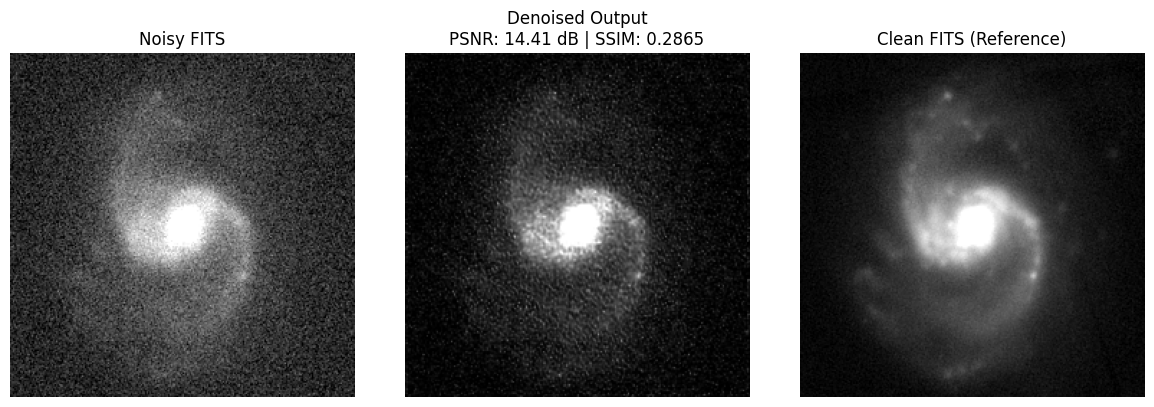

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from astropy.io import fits
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# -----------------------------
# 1. Define custom loss again
# -----------------------------
def ssim_mse_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.5 * mse_loss + 0.5 * ssim_loss

# -----------------------------
# 2. Load model with custom_objects
# -----------------------------
model_path = '/content/drive/MyDrive/PS1_Models/n2n_unet_finetuned_sdss.h5'  # Update with your fine-tuned model path
model = tf.keras.models.load_model(model_path, custom_objects={'ssim_mse_loss': ssim_mse_loss})
print("✅ Model loaded!")

# -----------------------------
# 3. Load FITS Image Pair (Noisy and Clean)
# -----------------------------
noisy_path = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"
clean_path = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"

def load_fits_normalized(path):
    with fits.open(path) as hdul:
        img = hdul[0].data.astype(np.float32)
        img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
        p1, p99 = np.percentile(img, (1, 99))
        img = np.clip(img, p1, p99)
        img = (img - p1) / (p99 - p1 + 1e-8)
        img = np.log1p(img) / np.log1p(1.0)
        return img

noisy_img = load_fits_normalized(noisy_path)
clean_img = load_fits_normalized(clean_path)

# Resize to 240x240 for model input
noisy_resized = tf.image.resize(noisy_img[..., np.newaxis], (240, 240)).numpy().squeeze()
clean_resized = tf.image.resize(clean_img[..., np.newaxis], (240, 240)).numpy().squeeze()

# -----------------------------
# 4. Predict denoised output
# -----------------------------
input_tensor = noisy_resized[np.newaxis, ..., np.newaxis]
denoised = model.predict(input_tensor, verbose=0)[0, ..., 0]

# -----------------------------
# 5. Evaluation Metrics (PSNR & SSIM)
# -----------------------------
psnr = psnr_metric(clean_resized, denoised, data_range=1.0)
ssim = ssim_metric(clean_resized, denoised, data_range=1.0)

print("\n📊 Evaluation Metrics:")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")

# -----------------------------
# 6. Visualization
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, img, title in zip(
    axes,
    [noisy_resized, denoised, clean_resized],
    ["Noisy FITS", f"Denoised Output\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}", "Clean FITS (Reference)"]
):
    ax.imshow(img, cmap="gray", vmin=np.percentile(img, 1), vmax=np.percentile(img, 99))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()
